In [28]:
# !pip install pytorch torchvision gdown

import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.datasets import CelebA
import torchvision
import numpy as np
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
# Loads the celebA dataset from pytorch datasets, and saves only 10000 images to local dir
# This is not needed if you already have the celebA dataset in the local dir

# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
#     # this centers the data around 0 and scales it to [-1, 1] - to make training more stable for the generator
# ])
#
# celebA = datasets.CelebA(root='data', split='all', download=True, transform=transform)
# # celebA = datasets.ImageFolder(root='data/celebA', transform=transform)
#
# # keep only 10000 random images
# celebA = torch.utils.data.Subset(celebA, torch.randperm(len(celebA))[:10000])
#
# # Split into train and test
# train_size, test_size = int(0.8 * len(celebA)), int(0.2 * len(celebA))
# train_set, test_set = torch.utils.data.random_split(celebA, [train_size, test_size])
#
# # save to local dir
# torch.save(train_set, 'data/celebA_train.pth')
# torch.save(test_set, 'data/celebA_test.pth')

Image shape: torch.Size([3, 128, 128])


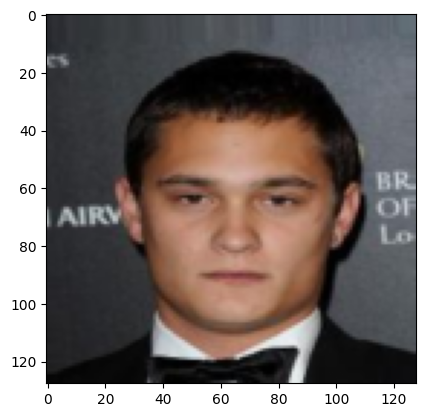

In [23]:
# Load the celebA dataset from local dir
train_set = torch.load('data/celebA_train.pth')
test_set = torch.load('data/celebA_test.pth')

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print("Image shape:", train_loader.dataset[0][0].shape)

def unnormalize(img):
    # unnormalize (we normalized the data to [-1, 1] before)
    return img / 2 + 0.5

img_sample = train_loader.dataset[0][0]
img_sample = unnormalize(img_sample)
plt.imshow(np.transpose(img_sample.numpy(), (1, 2, 0))) # transpose (C, H, W) -> (H, W, C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


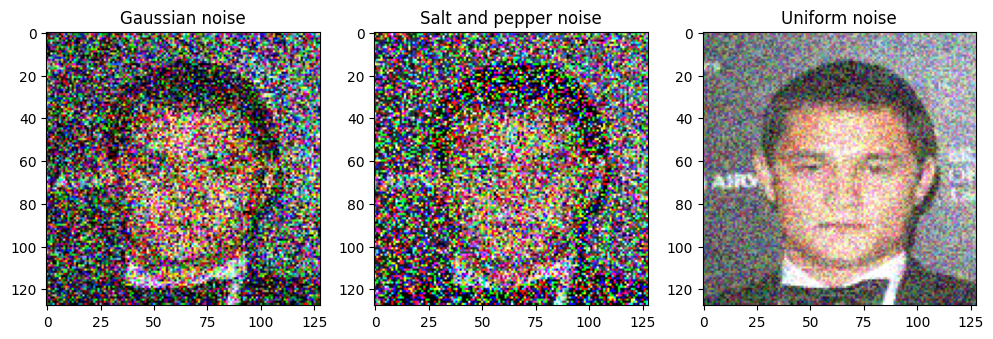

In [26]:
# Different noise functions
def gaussian_noise(image, noise_level):
    image_clone = image.clone()
    noise = torch.randn_like(image) * noise_level
    return image_clone + noise

def salt_and_pepper_noise(image, noise_level):
    image_clone = image.clone()
    noise = torch.rand_like(image_clone)
    image_clone[noise < noise_level / 2] = 0
    image_clone[noise > 1 - noise_level / 2] = 1
    return image_clone

def uniform_noise(image, noise_level):
    image_clone = image.clone()
    noise = torch.rand_like(image_clone) * noise_level
    return image_clone + noise

# Plot one example of each noise type in a grid
gaussian_sample = gaussian_noise(img_sample, 0.5)
salt_and_pepper_sample = salt_and_pepper_noise(img_sample, 0.5)
uniform_sample = uniform_noise(img_sample, 0.5)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(gaussian_sample.numpy().transpose(1, 2, 0))
ax[0].set_title('Gaussian noise')
ax[1].imshow(salt_and_pepper_sample.numpy().transpose(1, 2, 0))
ax[1].set_title('Salt and pepper noise')
ax[2].imshow(uniform_sample.numpy().transpose(1, 2, 0))
ax[2].set_title('Uniform noise')
plt.show()

In [29]:
from model import Generator, Discriminator

generator = Generator(in_channels=3)
discriminator = Discriminator(input_size=128*128, in_channels=3)

# Loss function
criterion = nn.BCEWithLogitsLoss()
content_criterion = nn.L1Loss()

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.001, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001, betas=(0.5, 0.999))

In [41]:
# Training loop, uses cpu for now
generator.train()
discriminator.train()
num_epochs = 1
noise_level = 0.5

losses_gen, losses_disc = [], []

for epoch in range(num_epochs):
    for i, (real_images, _) in enumerate(tqdm(train_loader)): # _ is the label, we don't have it here
        # Test the training:
        # if i == 5:
        #     break

        # Add noise to the real images
        real_images_noisy = gaussian_noise(real_images, noise_level)

        # Train the discriminator
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()

        fake_images = generator(real_images_noisy)
        real_disc = discriminator(real_images)
        fake_disc = discriminator(fake_images)

        real_loss = criterion(real_disc, torch.ones_like(real_disc))
        fake_loss = criterion(fake_disc, torch.zeros_like(fake_disc))
        disc_loss = (real_loss + fake_loss) / 2

        disc_loss.backward()
        discriminator_optimizer.step()

        # Train the generator
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()

        fake_images = generator(real_images_noisy)
        fake_disc = discriminator(fake_images)

        content_loss = content_criterion(fake_images, real_images)
        gen_loss = 0.1 * criterion(fake_disc, torch.ones_like(fake_disc)) + 0.9 * content_loss

        gen_loss.backward()
        generator_optimizer.step()

        if i % 100 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                  f"Generator loss: {gen_loss.item():.4f}, Discriminator loss: {disc_loss.item():.4f}")

        losses_gen.append(gen_loss.item())
        losses_disc.append(disc_loss.item())

    # Checkpoint the model after each epoch
    torch.save(generator.state_dict(), f'generator_epoch_{epoch}.pth')
    torch.save(discriminator.state_dict(), f'discriminator_epoch_{epoch}.pth')

  0%|          | 1/250 [00:20<1:25:12, 20.53s/it]

Epoch [0/1], Step [0/250], Generator loss: 1.1756, Discriminator loss: 0.0018


  2%|▏         | 5/250 [01:19<1:04:54, 15.89s/it]


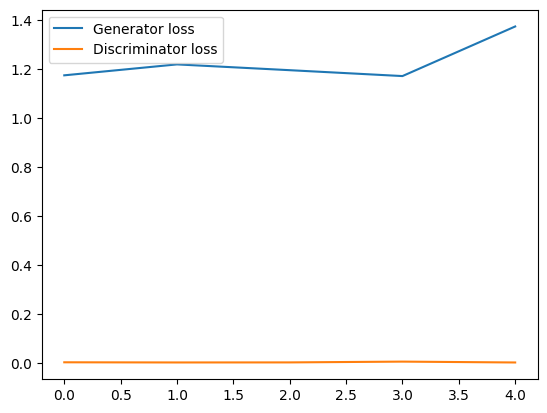

In [42]:
# Plot the losses
plt.plot(losses_gen, label='Generator loss')
plt.plot(losses_disc, label='Discriminator loss')
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


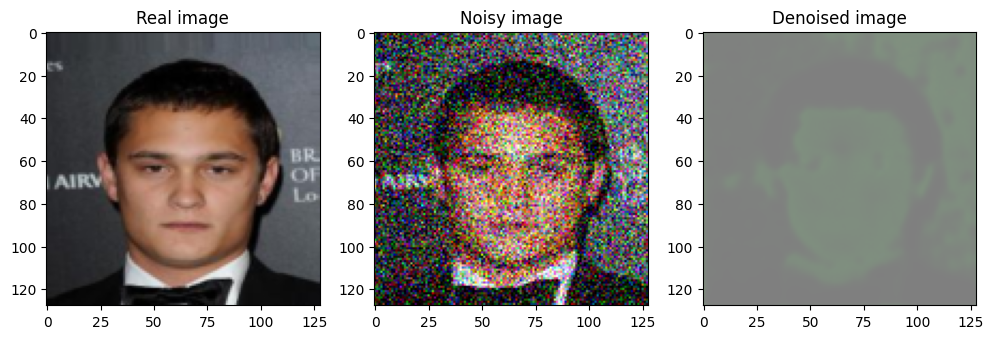

In [40]:
# Visualize the denoising
generator.eval()
discriminator.eval()

real_image = train_loader.dataset[0][0].unsqueeze(0)
real_image_noisy = gaussian_noise(real_image, noise_level)
fake_image = generator(real_image_noisy)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(unnormalize(real_image).numpy().squeeze().transpose(1, 2, 0))
ax[0].set_title('Real image')
ax[1].imshow(unnormalize(real_image_noisy).squeeze().numpy().transpose(1, 2, 0))
ax[1].set_title('Noisy image')
ax[2].imshow(unnormalize(fake_image).detach().squeeze().numpy().transpose(1, 2, 0))
ax[2].set_title('Denoised image')
plt.show()